<h4 align="center">
LIMPIEZA Y MODIFICACION DE DATOS
</h4>

In [449]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import ticker
import seaborn as sns
import textwrap

df_totales_grado = None #uso posterior para regresion

#Leemos el dataset original
df = pd.read_csv('data/matriculaciones_educacion_escolar_basica_2020.csv')

#Eliminamos una columna que no posee datos
df = df.drop(columns='anho_cod_geo')


#Renombrar nombre de las columnas
df = df.rename(columns={
    'anio':'año', 'nombre_departamento':'departamento', 'nombre_distrito': 'distrito', 
    'nombre_zona': 'zona', 'nombre_barrio_localidad': 'localidad', 'nombre_institucion': 'institucion', 
    'sector_o_tipo_gestion': 'sector'
})


#Indexacion y ordenamiento
df = df.set_index('departamento')
df = df.sort_values(['departamento', 'distrito', 'localidad'])


#Limpieza de la columna 'nombre_barrio_localidad' ('localidad') y 'codigo_barrio_localidad'
df.loc[
    (df['localidad'] == 'LOCALIDAD DE CONFIRMAR') 
    | (df['localidad'] == 'LOCALIDAD A CONFIRMAR') 
    | (df['localidad'] == 'LOCALIDAD A  CONFIRMAR'), 'localidad'
] = 'LOCALIDAD A CONFIRMAR'

df.loc[df['localidad'] == 'LOCALIDAD A CONFIRMAR', 'codigo_barrio_localidad'] = '0'

#Agregamos una nueva columna
df['total_matriculados'] = df['total_matriculados_hombre'] + df['total_matriculados_mujer']

<h5>OBJETIVO 1:</h6>
Visualizar gráficamente la distribución de matriculados en la educación escolar básica por departamento.

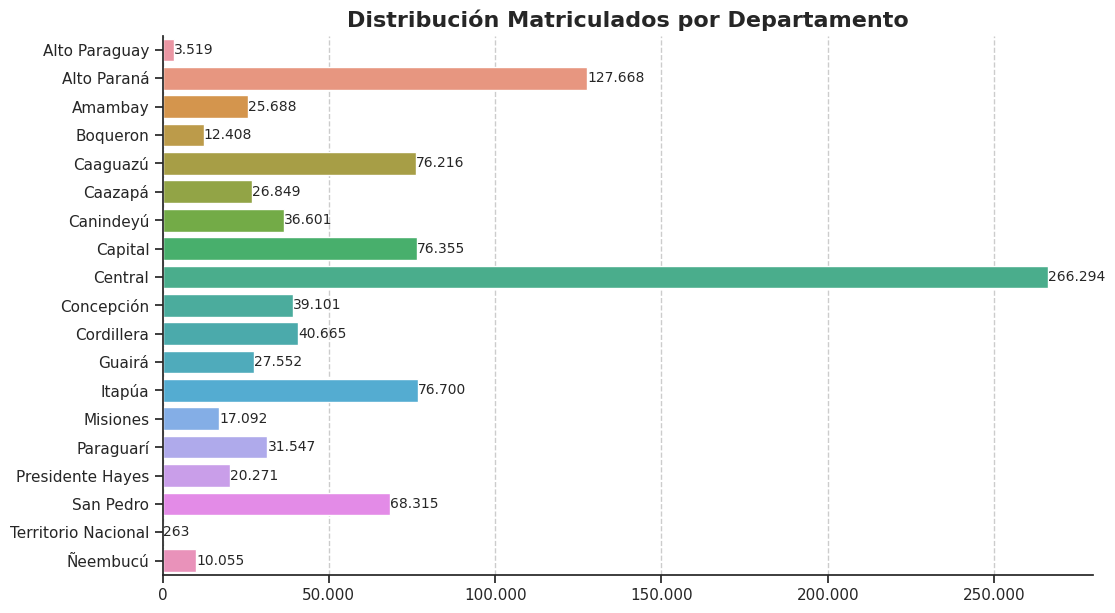

In [450]:
general_format = {'figure.figsize':(12, 7), 'grid.linestyle': '--', 'axes.spines.right': False, 'axes.spines.top': False}
sns.set_theme(style='ticks', rc = general_format)

#Agrupamos por departamento y obtenemos el total de matriculados
df_departamento = df.groupby(['departamento']).agg({'total_matriculados':'sum'})

#Exportamos a csv
df_departamento.to_csv('data/resumen_departamento_total.csv', encoding = 'utf-8-sig')

df_departamento = df_departamento.reset_index()

# Establecemos la sesión como no-interactiva.
plt.close('all')
plt.ioff()

# Diagramamos el gráfico de barras.
ax = sns.barplot(y = 'departamento', x = 'total_matriculados', data = df_departamento, errorbar = None)
ax.bar_label(ax.containers[0], fontsize = 10, labels = [f'{x:,.0f}'.replace(',', '.') for x in ax.containers[0].datavalues])

# Formatemos los labels del eje x
xlabels = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(ticker.FixedLocator(xlabels))
ax.set_xticklabels([f'{x:,.0f}'.replace(',', '.') for x in xlabels]) 

# Cambios visuales
ax.set(xlabel = None, ylabel = None)
ax.axes.set_title('Distribución Matriculados por Departamento', fontsize = 16, weight = 'bold')
ax.grid(visible = True)
ax.yaxis.grid(False)

# Mostramos el gráfico.
plt.show()

<h5>OBJETIVO 2:</h6>
Representar la distribución de matriculados en la educación escolar básica por distrito.

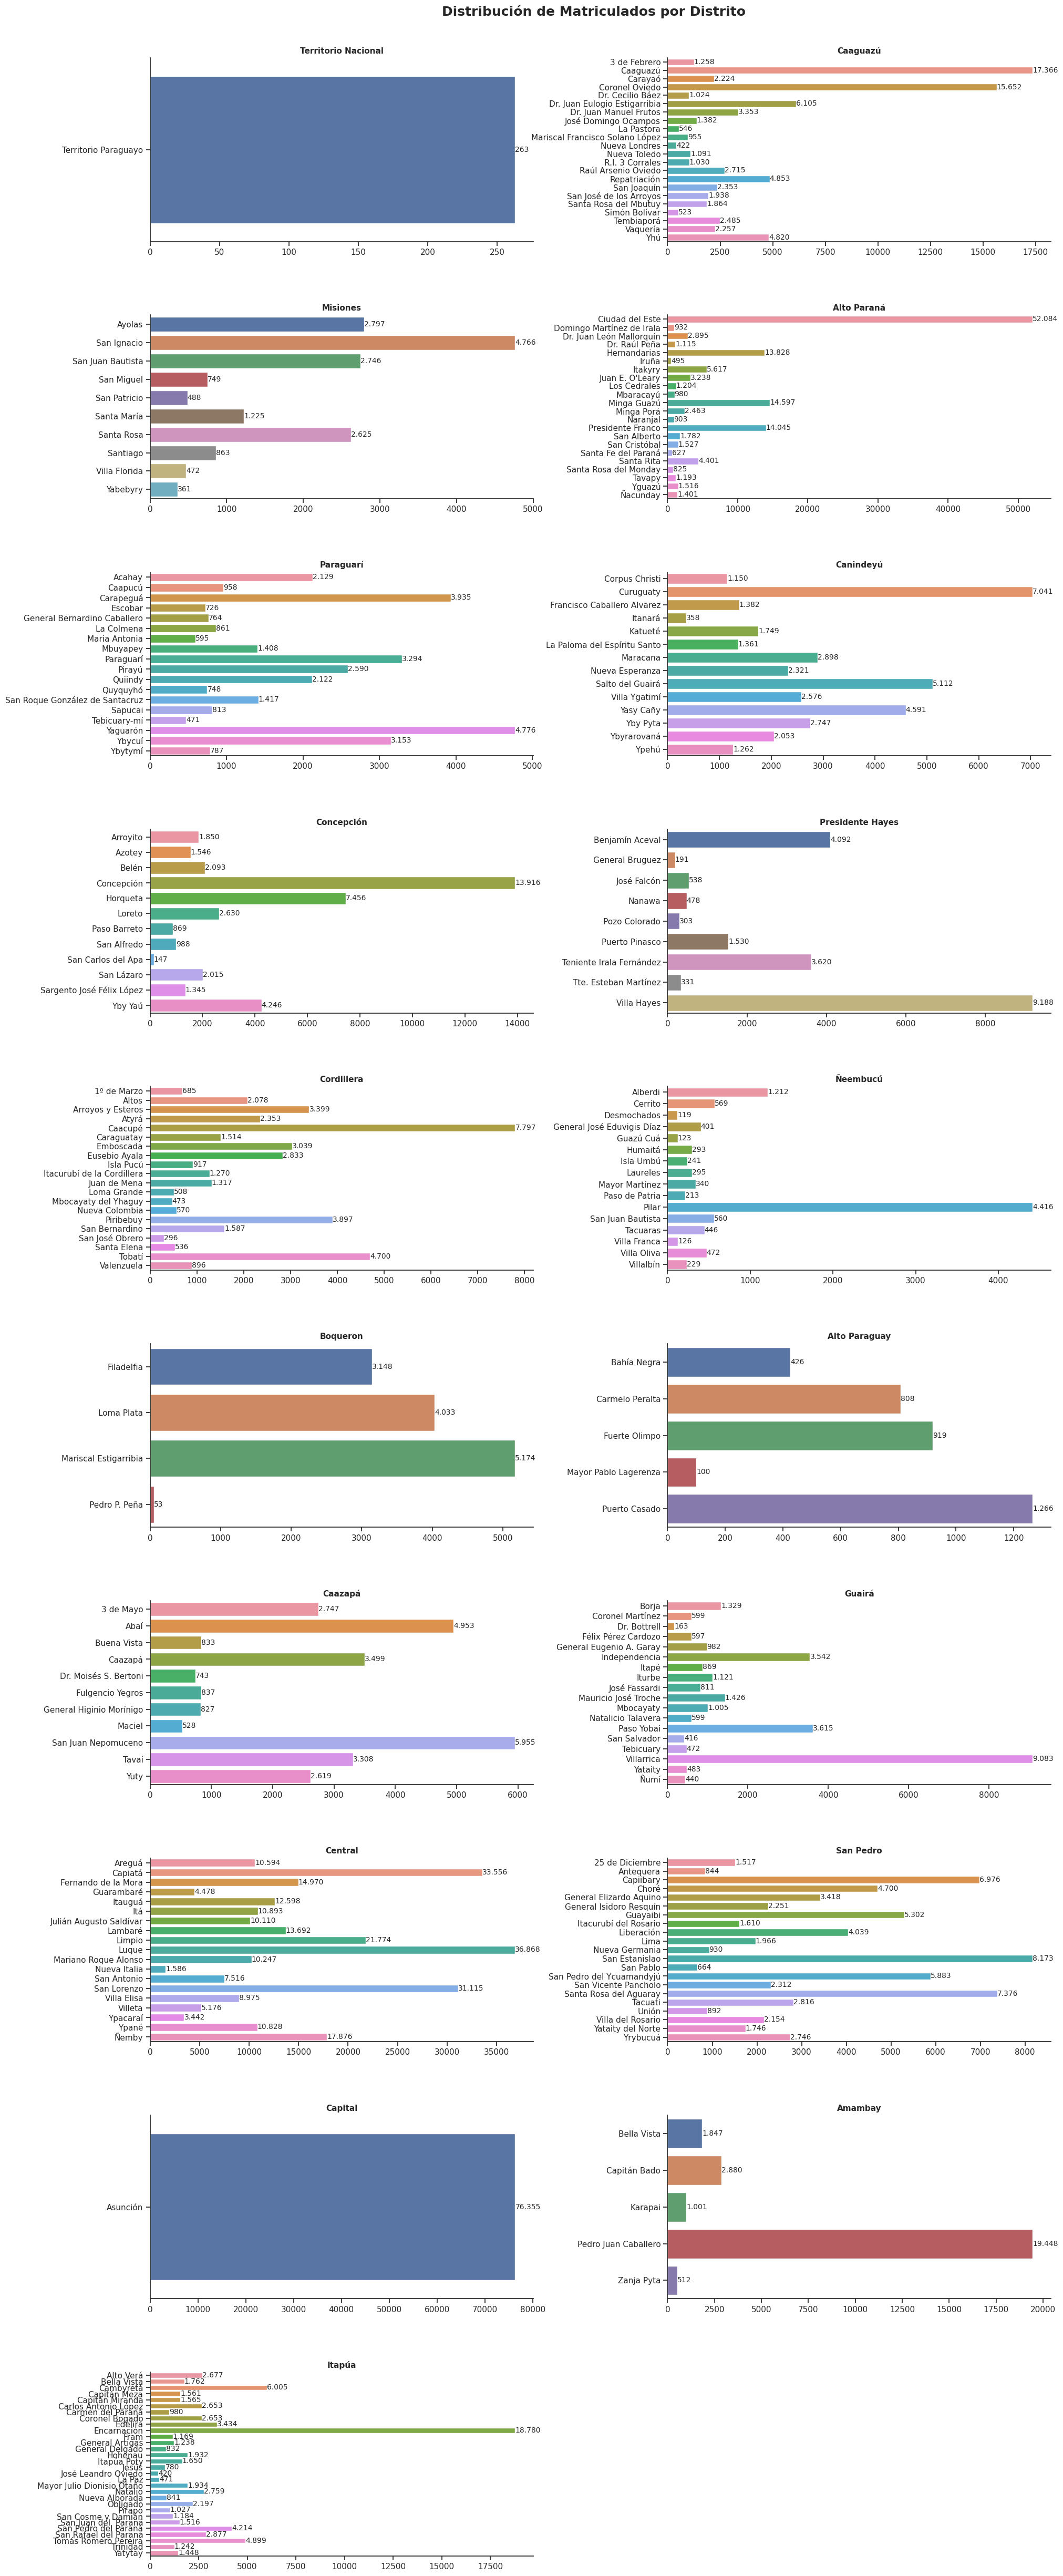

In [451]:
#Agrupamos por departamento y distrito, obtenemos el total de matriculados
df_distrito = df.groupby(['departamento', 'distrito']).agg({'total_matriculados':'sum'})


#Exportamos a csv
df_distrito.to_csv('data/resumen_distrito_total.csv', encoding = 'utf-8-sig')

#Quitamos la columna 'distrito' del indice
df_distrito = df_distrito.reset_index(level=1)


# Establecemos la sesión como no-interactiva.
plt.close('all')
plt.ioff()


# Definimos los subplots con la cantidad total de departamentos que tenemos de nuestros datos
cantidad_filas = 10
cantidad_columnas = 2
fig, axes = plt.subplots(cantidad_filas, cantidad_columnas, figsize=(18,50))

# Configuraciones de espaciados y ajustes visuales de los graficos
fig.tight_layout()
fig.subplots_adjust(top=0.96, wspace=0.35, hspace=0.4)


# Eliminamos el ultimo subgrafico
fig.delaxes(axes[cantidad_filas - 1][cantidad_columnas - 1])

# Definimos el titulo general del los graficos
plt.suptitle('Distribución de Matriculados por Distrito', fontsize = 18, fontweight='bold', verticalalignment='top')


# Obtenemos la lista de departamentos
lista_departamentos = list(set(df_distrito.index))


indice_departamentos = 0

# Cargamos cada uno de los subgraficos con los datos de los distintos distritos
for i in range(cantidad_filas):
    for j in range(cantidad_columnas):
        if indice_departamentos > len(lista_departamentos) - 1:
            break
        
        # Obtenemos los datos de los distritos y la cantidad de matriculados en ese distrito, de acuerdo al departamento correspondiente
        datos_distrito = df_distrito.loc[lista_departamentos[indice_departamentos]]

        # Para el caso de 'Territorio Nacional' y 'Capital' que tiene 1 solo distrito, retorna una serie, entonces transformamos para poder utilizarlo en el grafico
        if isinstance(datos_distrito, pd.Series):
            datos_distrito = datos_distrito.to_frame().transpose()
            
        datos_distrito = datos_distrito.reset_index()

        # Cargamos el subgrafico con los datos del departamento
        sns.barplot(x='total_matriculados', y='distrito', data = datos_distrito, ax = axes[i][j])
        axes[i][j].set_title(lista_departamentos[indice_departamentos], fontdict= { 'fontsize': 11, 'fontweight':'bold'})
        axes[i][j].bar_label(axes[i][j].containers[0], fontsize = 10, labels = [f'{x:,.0f}'.replace(',', '.') for x in axes[i][j].containers[0].datavalues])
        axes[i][j].set_ylabel(None) 
        axes[i][j].set_xlabel(None)

        indice_departamentos = indice_departamentos + 1



# Mostramos el gráfico.
plt.show()



<h5>OBJETIVO 3:</h6>
Plasmar gráficamente la distribución de matriculados en la educación escolar básica por localidad.

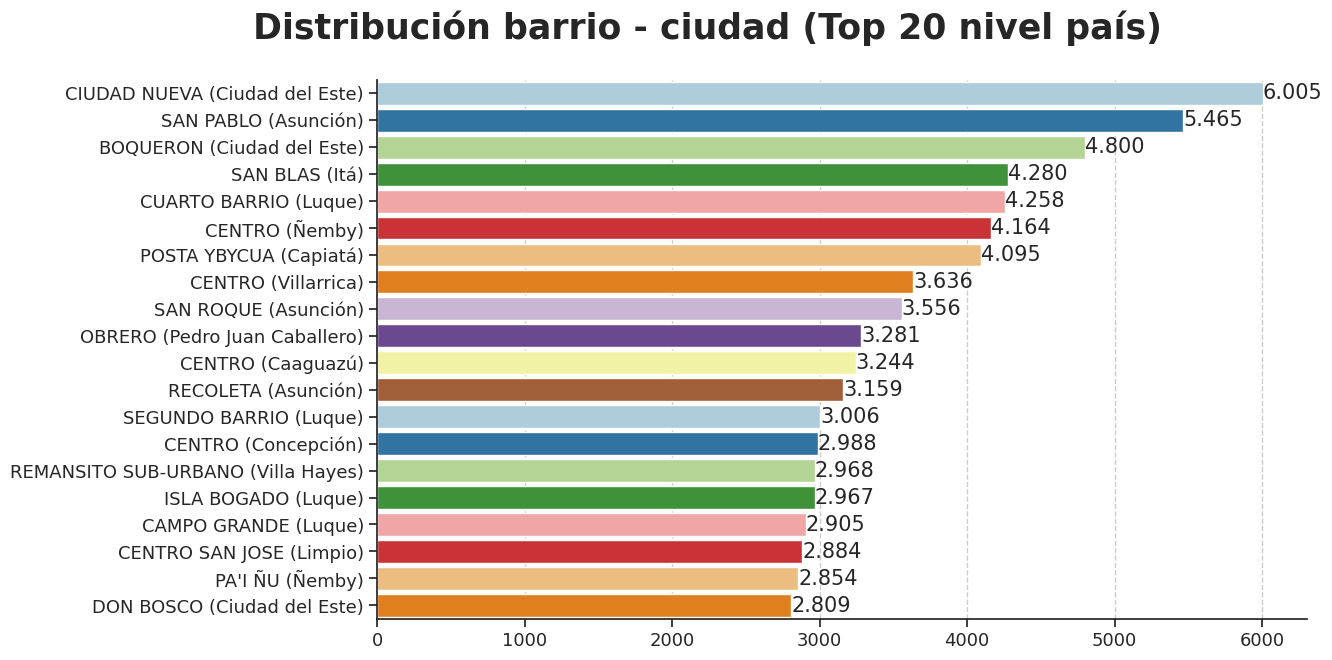

In [452]:
# Establecemos el top
top_global_barrios = 20

# formateamos el indice
df_barrios = df.reset_index()

# Concatenamos el campo barrio con el siguiente formato "barrio (ciudad correspondiente)"
df_barrios['localidad'] = df_barrios['localidad'] + ' (' + df_barrios['distrito'] + ')'

# Determinamos los indices
df_barrios = df_barrios.set_index(['departamento','localidad'])

# Agregamos la suma agrupando por departamento y barrio
df_barrios = df_barrios.groupby(['departamento', 'localidad']).agg({'total_matriculados' : 'sum'})

# Ordenamos segun la cantidad por departamento y localidad, para obtener un top 
df_barrios_top = df_barrios.groupby('departamento', group_keys=False).apply(lambda x: x.sort_values('total_matriculados', ascending=False))
df_barrios_top = df_barrios_top.groupby('departamento').head(top_global_barrios)[['total_matriculados']]

df_barrios_top_global = df_barrios_top.reset_index()
df_barrios_top_global = df_barrios_top_global.drop(columns='departamento').nlargest(top_global_barrios, 'total_matriculados', keep='all')

#Exportamos a csv
df_barrios_top_global.to_csv('data/resumen_top_localidad_matriculados.csv', encoding = 'utf-8-sig')

# Establecemos la sesión como no-interactiva.
plt.close('all')
plt.ioff()

# Creamos la figura contenedora.
tamanho_grilla = (1, 2)
fig = plt.figure()
axes = []

# Establecemos los subgráficos 
axes.append(plt.subplot2grid(tamanho_grilla, (0,0), colspan=2, rowspan=1))

# Ajustamos el espacio entre los subgraficos
fig.subplots_adjust(hspace=0.3)

# Establecemos el super-titulo.
fig.suptitle(f'Distribución barrio - ciudad (Top {top_global_barrios} nivel país)', 
             x=+0.40, 
             horizontalalignment='center', 
             verticalalignment='top', 
             fontsize = 25,
             fontweight='bold')

# Establecemos la paleta de colores
colores = sns.husl_palette(s=.4) #sns.color_palette("husl", 9)

graf_barr1 = sns.barplot(x='total_matriculados', y='localidad', data = df_barrios_top_global, ax = axes[0], palette='Paired', width=0.85)
#graf_barr1 = axes[0].set_title(f'Top {top_global_barrios} nivel país', fontdict= { 'fontsize': 12, 'fontweight':'bold'})
graf_barr1 = axes[0].bar_label(axes[0].containers[0], fontsize = 15, labels = [f'{x:,.0f}'.replace(',', '.') for x in axes[0].containers[0].datavalues])

# Eliminar el y-label and x-label
graf_barr1 = axes[0].set_ylabel(None) 
graf_barr1 = axes[0].set_xlabel(None)

# Cambios visuales
axes[0].set(xlabel = None, ylabel = None)
axes[0].grid(visible = True)
axes[0].yaxis.grid(False)
axes[0].yaxis.set_tick_params(labelsize = 13)
axes[0].xaxis.set_tick_params(labelsize = 13)

# Mostrar el grafico
plt.show()

<h5>OBJETIVO 4:</h6>
Reflejar mediante un gráfico la distribución de matriculados en la educación escolar básica por género.

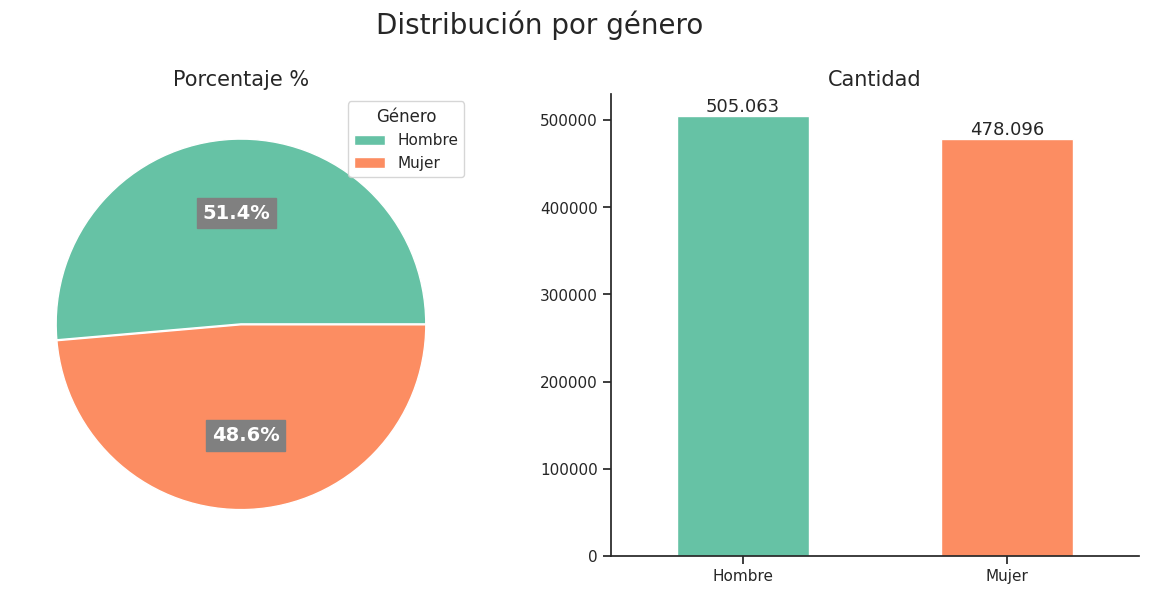

In [453]:
#Obtenemos la cantidad total por genero
df_genero = df.agg({'total_matriculados_hombre':'sum', 'total_matriculados_mujer':'sum'})


#Exportamos a csv
df_genero.to_csv('data/resumen_total_matriculados_genero.csv', encoding = 'utf-8-sig')

# Establecemos la sesión como no-interactiva.
plt.close('all')
plt.ioff()

# Creamos la figura contenedora.
fig, axes = plt.subplots(1, 2, figsize=(15,6))

# Establecemos el super-titulo.
fig.suptitle('Distribución por género', size=20, y=1.02)

# Establecemos los colores
colors = sns.color_palette("Set2")

# Diagramamos los datos con el grafico de pastel (Grafico 1)
graf1 = df_genero.plot(kind='pie', 
               ax=axes[0], 
               title='Porcentaje %',
               colors=colors,
               shadow=False,
               autopct = '%0.1f%%',
               labels = None,
               explode = [0.005, 0],
               textprops={'fontsize': 14, 
                           'color': 'white', 
                           'backgroundcolor': 'gray',
                           'weight':'bold'})

# Estilo titulo grafico 1
graf1.title.set_size(15)

#Desactivamos el y-axis
graf1.axes.get_yaxis().set_visible(False)

# Diagramamos los datos según cantidad (Grafico 2)
graf2 = df_genero.plot(kind='bar', 
                       color=colors,
                       title='Cantidad')

# Estilo titulo grafico 1
graf2.title.set_size(15)

# Reenombramos los xticks
graf2.set_xticklabels(['Hombre', 'Mujer'], rotation=0)

# Establecemos los labels
graf2.bar_label(graf2.containers[0], fontsize = 13, labels = [f'{x:,.0f}'.replace(',', '.') for x in graf2.containers[0].datavalues])


# Agregamos las leyendas
leg_graf = axes[0].legend(['Hombre', 'Mujer'], loc="best", title='Género')

# Mostramos el gráfico.
plt.show()

<h5>OBJETIVO 5:</h6>
Representar la distribución de matriculados en la educación escolar básica por grado.

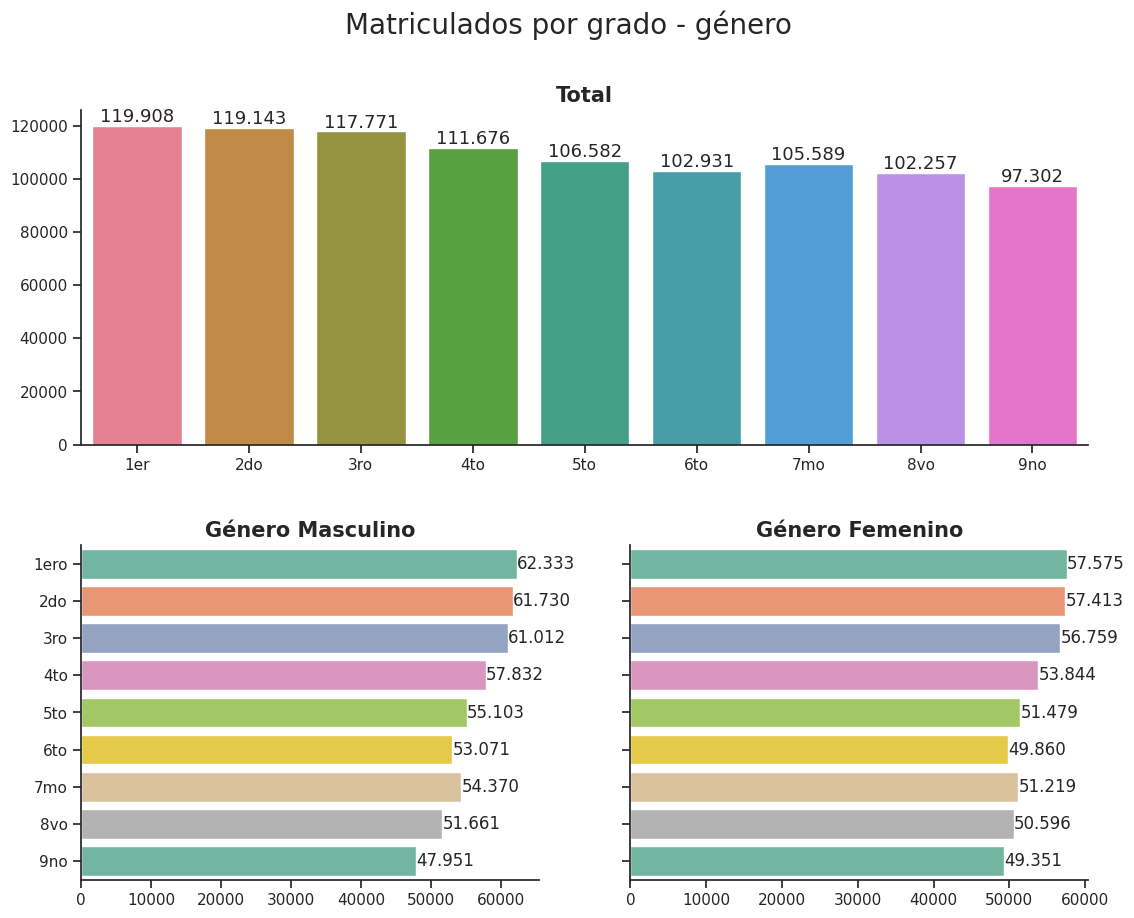

In [454]:
# Función para renombrar los campos
def change_name_columns(df, a, b):
    name = list(df.loc[:, a:b])
    df = df.rename(columns={name[0]: "1ero", 
                            name[1]: "2do",
                            name[2]: "3ro",
                            name[3]: "4to",
                            name[4]: "5to",
                            name[5]: "6to",
                            name[6]: "7mo",
                            name[7]: "8vo",
                            name[8]: "9no"})
    return df


# Obtener los indices de las columnas
lista_hombres = [x for x in range(12, 28+1) if x % 2 == 0]
lista_mujeres = [x for x in range(13, 29+1) if x % 2 != 0]

# Obtener el resumen por grado: género masculino
df_aux_men = df.iloc[:, lista_hombres].reset_index(level=0).drop(columns='departamento')
df_aux_men = change_name_columns(df_aux_men, 'primer_grado_hombre', 'noveno_grado_hombre')
df_aux_men = df_aux_men.sum().to_frame().reset_index(level=0).rename(columns={'index':'tipo', 0:"cantidad"})

# Obtener el resumen por grado: género femenino
df_aux_women = df.iloc[:, lista_mujeres].reset_index(level=0).drop(columns='departamento')
df_aux_women = change_name_columns(df_aux_women, 'primer_grado_mujer', 'noveno_grado_mujer')
df_aux_women = df_aux_women.sum().to_frame().reset_index(level=0).rename(columns={'index':'tipo', 0:"cantidad"})

# Obtener el resumen total por grado
total = df_aux_men.add(df_aux_women, fill_value=0)
total['tipo'] = total['tipo'].str.slice(0, 3)

df_totales_grado = total ##guardado de datos para regresion

#Exportamos a csv
df_totales_grado.to_csv('data/resumen_totales_grado.csv', encoding = 'utf-8-sig')


# Establecemos la sesión como no-interactiva.
plt.close('all')
plt.ioff()

# Creamos la figura contenedora.
tamanho_grilla = (2, 2)
fig = plt.figure(figsize=(13,10))
axes = []

# Establecemos los subgráficos 
axes.append(plt.subplot2grid(tamanho_grilla, (0,0), colspan=2, rowspan=1))
axes.append(plt.subplot2grid(tamanho_grilla, (1,0), colspan=1, rowspan=1))
axes.append(plt.subplot2grid(tamanho_grilla, (1,1), colspan=1, rowspan=1))

# Ajustamos el espacio entre los subgraficos
fig.subplots_adjust(hspace=0.3)

# Ayuda a aplicar más espacios entre los graficos
#fig.tight_layout()

# Establecemos el super-titulo.
fig.suptitle('Matriculados por grado - género', size=20)

# Establecemos la paleta de colores
colores = sns.color_palette("husl", 9)
colores2 = sns.color_palette("Set2")
colores3 = sns.color_palette("Set2")

# Diagramamos el gráfico de barras 1.
graf_3 = sns.barplot(x='tipo', y='cantidad', data = total, errorbar = None, ax=axes[0], palette=colores)
graf_3 = axes[0].set_title('Total', fontdict= { 'fontsize': 15, 'fontweight':'bold'})
graf_3 = axes[0].bar_label(axes[0].containers[0], fontsize = 13, labels = [f'{x:,.0f}'.replace(',', '.') for x in axes[0].containers[0].datavalues])

# Diagramamos el gráfico de barras 2.
graf_4 = sns.barplot(y='tipo', x='cantidad', data = df_aux_men, errorbar = None, ax=axes[1], palette=colores2)
graf_4 = axes[1].set_title('Género Masculino', fontdict= { 'fontsize': 15, 'fontweight':'bold'})
graf_4 = axes[1].bar_label(axes[1].containers[0], fontsize = 12, labels = [f'{x:,.0f}'.replace(',', '.') for x in axes[1].containers[0].datavalues])

# Diagramamos el gráfico de barras 3.
graf_5 = sns.barplot(y='tipo', x='cantidad', data = df_aux_women, errorbar = None, ax=axes[2], palette=colores3)
graf_5 = axes[2].set_title('Género Femenino', fontdict= { 'fontsize': 15, 'fontweight':'bold'})
graf_5 = axes[2].bar_label(axes[2].containers[0], fontsize = 12, labels = [f'{x:,.0f}'.replace(',', '.') for x in axes[2].containers[0].datavalues])

# Desactivamos el y-tick ya que comparte con el gráfico de la izquierda
plt.setp(axes[2].get_yticklabels(), visible=False)

# Eliminar el y-label and x-label
graf_3 = axes[0].set_ylabel(None) 
graf_3 = axes[0].set_xlabel(None)

graf_4 = axes[1].set_ylabel(None) 
graf_4 = axes[1].set_xlabel(None)

graf_5 = axes[2].set_ylabel(None) 
graf_5 = axes[2].set_xlabel(None)

# Mostramos el gráfico.
plt.show()

<h5>OBJETIVO 6:</h6>
Plasmar gráficamente la distribución de matriculados en la educación escolar básica por ciclo (primer ciclo, segundo ciclo, tercer ciclo).

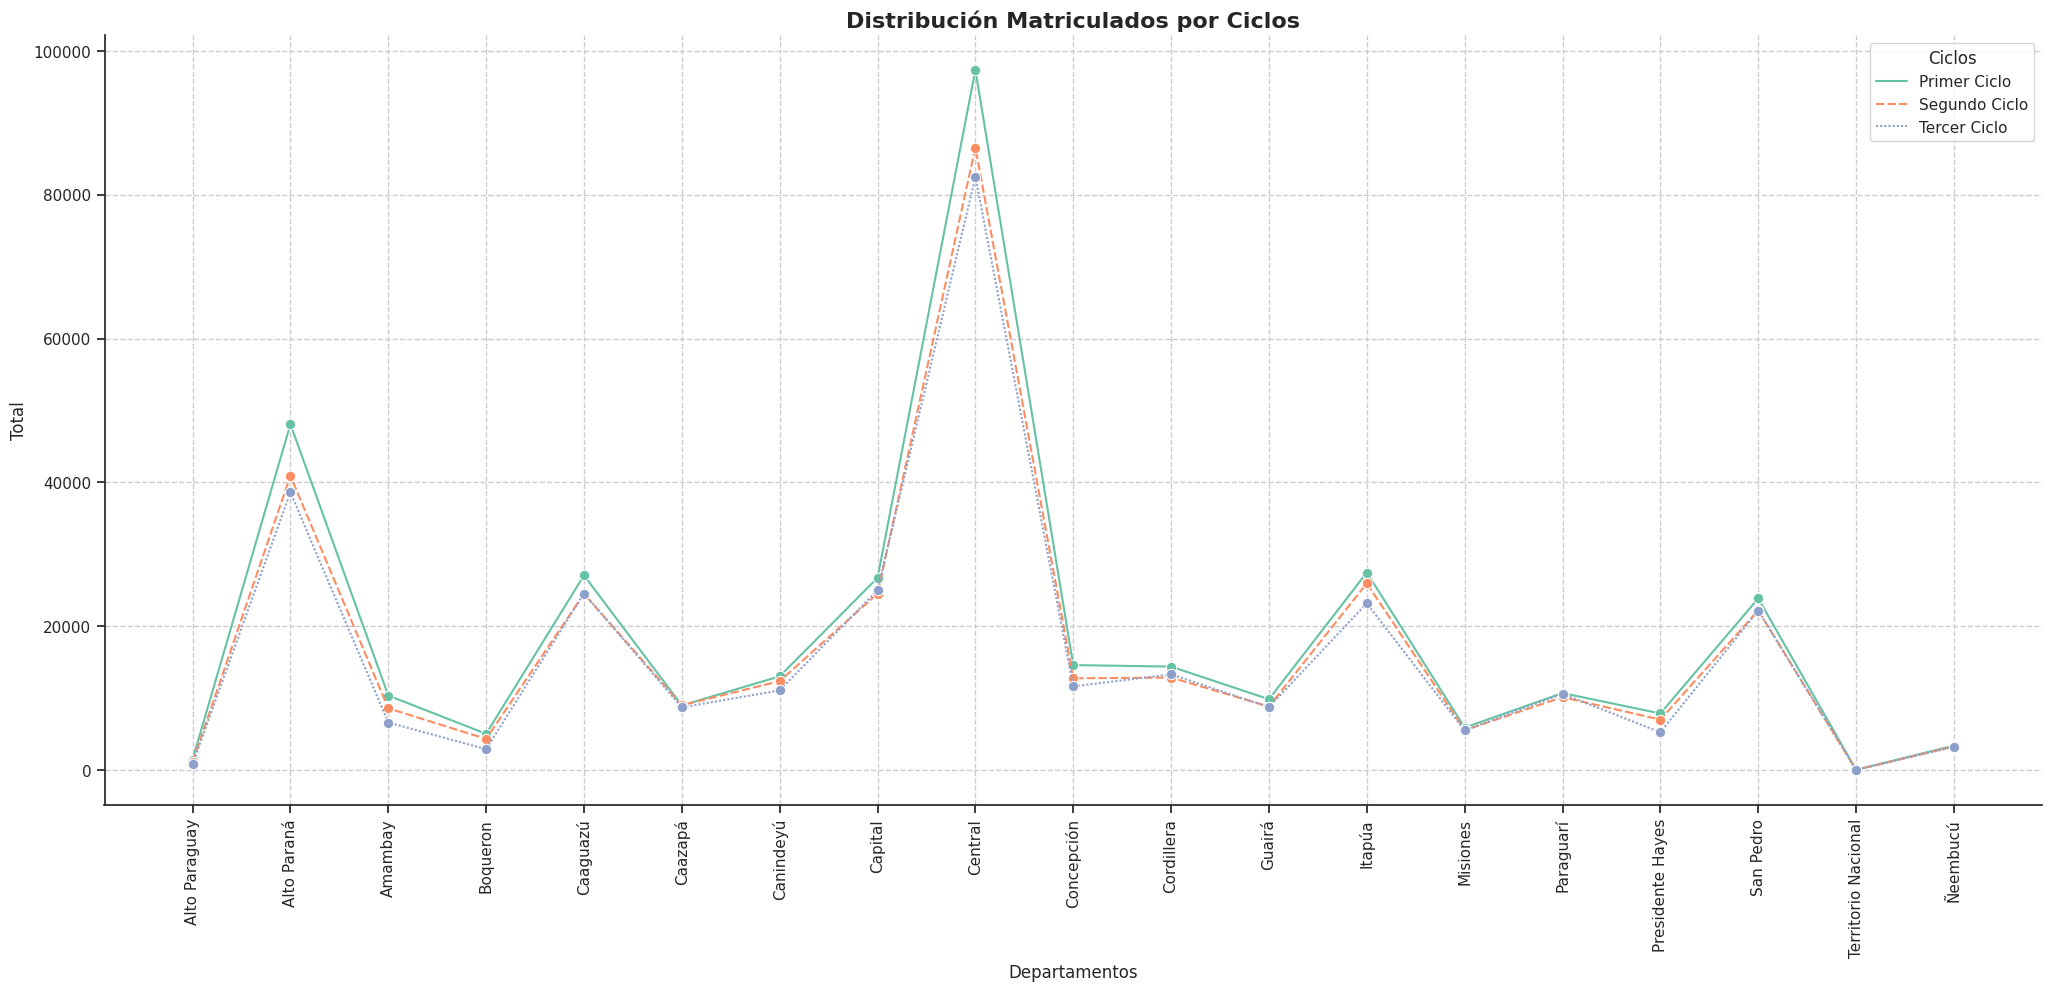

In [455]:
general_format = {'figure.figsize':(25, 10), 'grid.linestyle': '--', 'axes.spines.right': False, 'axes.spines.top': False}
sns.set_theme(style='ticks', rc = general_format)
					
'''
Agregamos columnas nuevas sumando:
    - primer_ciclo: primer al tercer grado
    - segundo_ciclo: cuarto al sexto grado
    - tercer_ciclo: septimo al noveno grado
'''
df_ciclos = df
df_ciclos['total_primer_ciclo'] = df['primer_grado_hombre'] + df['primer_grado_mujer'] + df['segundo_grado_hombre'] + df['segundo_grado_mujer'] + df['tercer_grado_hombre'] + df['tercer_grado_mujer']
df_ciclos['total_segundo_ciclo'] = df['cuarto_grado_hombre'] + df['cuarto_grado_mujer'] + df['quinto_grado_hombre'] + df['quinto_grado_mujer'] + df['sexto_grado_hombre'] + df['sexto_grado_mujer']
df_ciclos['total_tercer_ciclo'] = df['septimo_grado_hombre'] + df['septimo_grado_mujer'] + df['octavo_grado_hombre'] + df['octavo_grado_mujer'] + df['noveno_grado_hombre'] + df['noveno_grado_mujer']

#Agrupamos por departamento y obtenemos el total de matriculados por cada uno de los ciclos
df_ciclos = df.groupby(['departamento']).agg({'total_primer_ciclo':'sum', 'total_segundo_ciclo':'sum', 'total_tercer_ciclo':'sum'})

#Exportamos a csv
df_ciclos.to_csv('data/resumen_ciclos_total.csv', encoding = 'utf-8-sig')

#df_ciclos = df_ciclos.reset_index()
df_ciclos = df_ciclos.reset_index()


# Establecemos la sesión como no-interactiva.
plt.close('all')
plt.ioff()

# Diagramamos el gráfico de barras, pero reagrupamos los datos utilizando 'melt' ya que son mas de 1 variable
ax = sns.lineplot(data=df_ciclos.melt(id_vars='departamento', value_name='total_ciclos', var_name='Ciclos'),
                                    x='departamento', y='total_ciclos', hue='Ciclos', style='Ciclos', palette='Set2', marker='.', markersize=15)


# Cambios visuales
ax.set(xlabel = 'Departamentos', ylabel = 'Total')
ax.axes.set_title('Distribución Matriculados por Ciclos', fontsize = 16, weight = 'bold')
ax.tick_params(axis='x', rotation=90)
ax.yaxis.grid(True)
ax.xaxis.grid(True)


# Renombramos las leyendas
legend_labels, _= ax.get_legend_handles_labels()
ax.legend(legend_labels, ['Primer Ciclo', 'Segundo Ciclo', 'Tercer Ciclo'], title='Ciclos')


# Mostramos el gráfico.
plt.show()


<h5>OBJETIVO 7:</h6>
Obtener un top de instituciones con mayor cantidad de matriculados a nivel país.

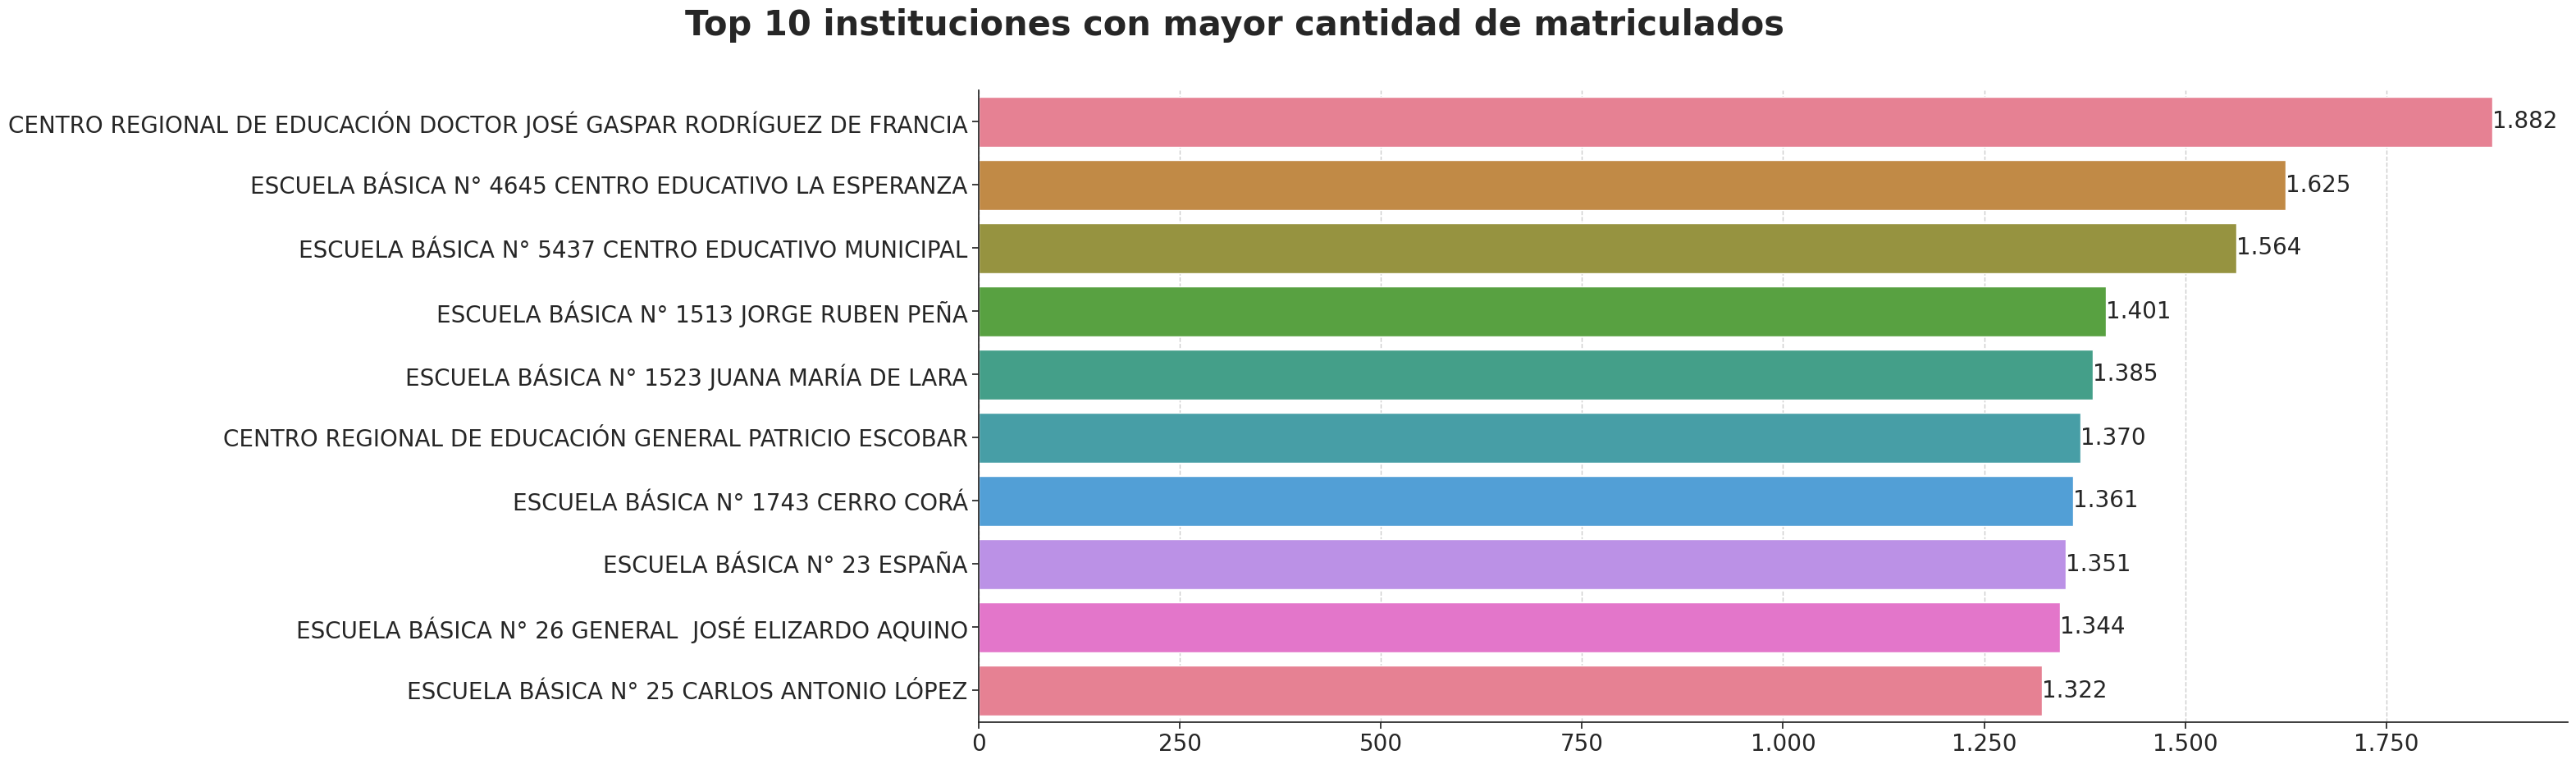

In [456]:
# Obtenemos el top de instituciones con mayor cantidad de matriculados
df_top_pais = df[['institucion', 'total_matriculados']].reset_index()
df_top_pais = df_top_pais.drop(columns='departamento').nlargest(10, 'total_matriculados', keep='all')

#Exportamos a csv
df_top_pais.to_csv('data/resumen_top_instituciones.csv', encoding = 'utf-8-sig')

# Establecemos la sesión como no-interactiva.
plt.close('all')
plt.ioff()

# Establecemos la paleta de colores
colores = sns.color_palette("husl", 9)

# Creamos la figura contenedora.
tamanho_grilla = (1, 1)
fig = plt.figure()
ax = []

# Establecemos el super-titulo.
fig.suptitle('Top 10 instituciones con mayor cantidad de matriculados', 
             x=+0.25, 
             horizontalalignment='center', 
             verticalalignment='top', 
             fontsize = 30,
             fontweight='bold')

# Diagramamos el gráfico de barras.
ax = sns.barplot(y = 'institucion', x = 'total_matriculados', data = df_top_pais, errorbar = None, palette=colores)
ax.bar_label(ax.containers[0], fontsize = 20, labels = [f'{x:,.0f}'.replace(',', '.') for x in ax.containers[0].datavalues])

# Formatemos los labels del eje x
xlabels = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(ticker.FixedLocator(xlabels))
ax.set_xticklabels([f'{x:,.0f}'.replace(',', '.') for x in xlabels]) 

# Cambios visuales
ax.set(xlabel = None, ylabel = None)
ax.grid(visible = True)
ax.yaxis.grid(False)
ax.yaxis.set_tick_params(labelsize = 20);
ax.xaxis.set_tick_params(labelsize = 20);

# Mostramos el gráfico.
plt.show()

<h5>OBJETIVO 8:</h6>
Elaborar un top de instituciones con mayor cantidad de matriculados por departamento.

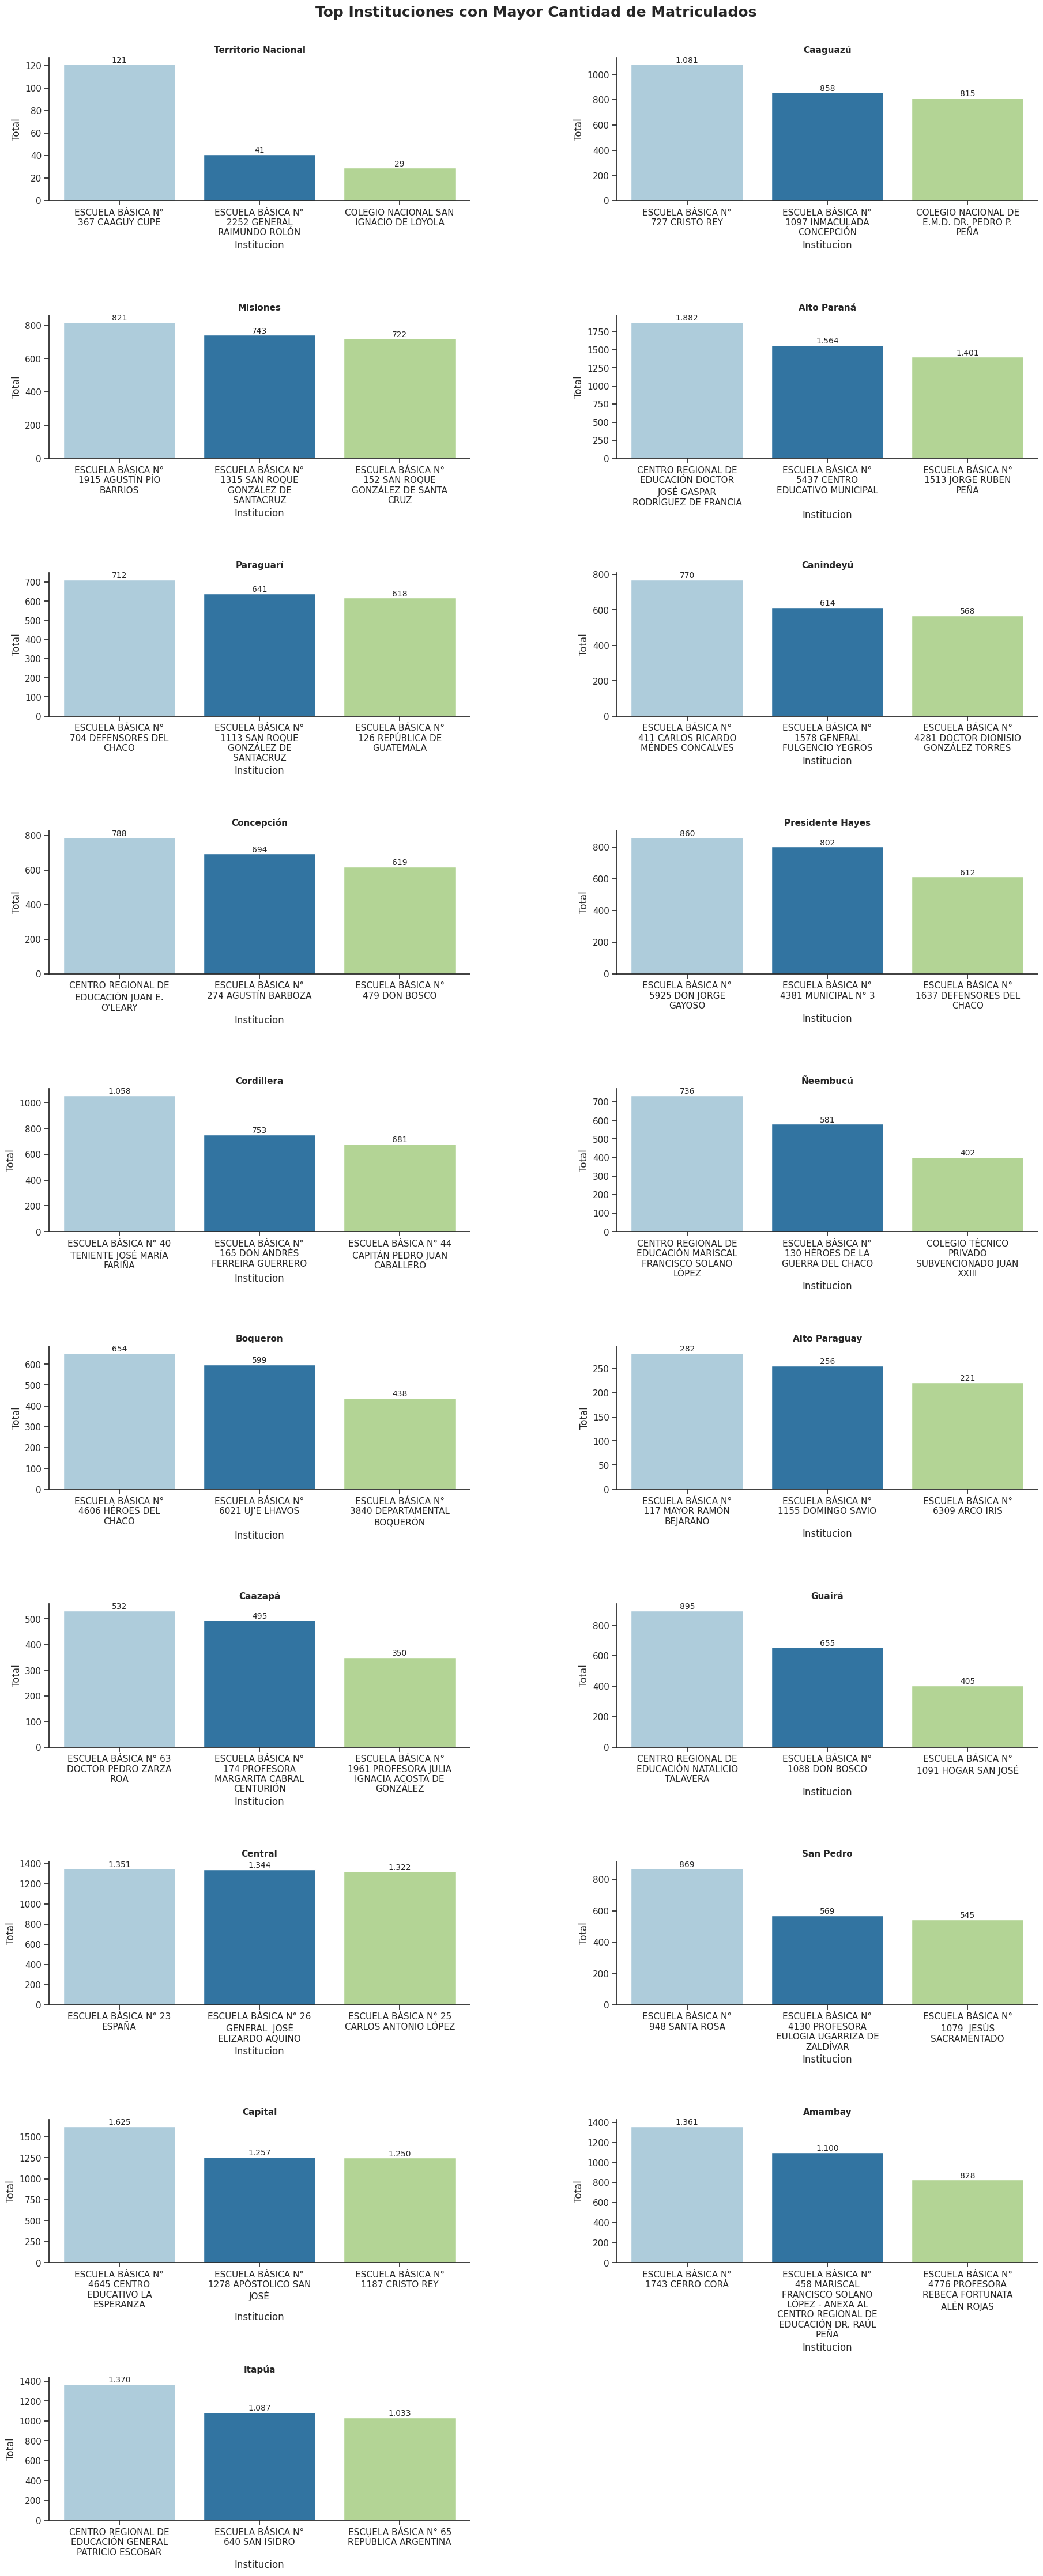

In [457]:
#Copiamos los datos en una variable
df_datos = df

#Removemos el indice 'departamento' para posteriormente establecer 'departamento' e 'institucion' como nuevos indices
df_datos = df_datos.reset_index()
df_datos = df_datos.set_index(['departamento','institucion'])

#Agrupamos los datos y ordenamos el 'total_matriculados' de mayor a menor
df_top_departamento_institucion = df_datos.groupby('departamento', group_keys=False).apply(lambda x: x.sort_values('total_matriculados', ascending=False))

#Agrupamos nuevamento para obtener el top 3 instituciones de cada departamento
df_top_departamento_institucion = df_top_departamento_institucion.groupby('departamento').head(3)[['total_matriculados']]

#Exportamos a csv
df_top_departamento_institucion.to_csv('data/resumen_top_departamento_institucion_total.csv', encoding = 'utf-8-sig')


#Quitamos la columna 'institucion' del indice
df_top_departamento_institucion = df_top_departamento_institucion.reset_index(level=1)

# Establecemos la sesión como no-interactiva.
plt.close('all')
plt.ioff()


# Definimos los subplots con la cantidad total de departamentos que tenemos de nuestros datos
cantidad_filas = 10
cantidad_columnas = 2
fig, axes = plt.subplots(cantidad_filas, cantidad_columnas, figsize=(18,45))

# Configuraciones de espaciados y ajustes visuales de los graficos
fig.tight_layout()
fig.subplots_adjust(top=0.96, wspace=0.35, hspace=0.8)


# Eliminamos el ultimo subgrafico
fig.delaxes(axes[cantidad_filas - 1][cantidad_columnas - 1])

# Definimos el titulo general del los graficos
plt.suptitle('Top Instituciones con Mayor Cantidad de Matriculados', fontsize = 18, fontweight='bold', verticalalignment='top')


# Obtenemos la lista de departamentos
lista_departamentos = list(set(df_distrito.index))


indice_departamentos = 0

# Cargamos cada uno de los subgraficos con los datos de los distintos distritos
for i in range(cantidad_filas):
    for j in range(cantidad_columnas):
        if indice_departamentos > len(lista_departamentos) - 1:
            break
        
        # Obtenemos los datos de los distritos y la cantidad de matriculados en ese distrito, de acuerdo al departamento correspondiente
        datos_institucion = df_top_departamento_institucion.loc[lista_departamentos[indice_departamentos]]

        datos_institucion = datos_institucion.reset_index()

        # Cargamos el subgrafico con los datos del departamento
        sns.barplot(y='total_matriculados', x='institucion', data = datos_institucion, ax = axes[i][j], palette='Paired')
        axes[i][j].set_title(lista_departamentos[indice_departamentos], fontdict= { 'fontsize': 11, 'fontweight':'bold'})
        axes[i][j].bar_label(axes[i][j].containers[0], fontsize = 10, labels = [f'{x:,.0f}'.replace(',', '.') for x in axes[i][j].containers[0].datavalues])
        axes[i][j].set_ylabel('Total') 
        axes[i][j].set_xlabel('Institucion')

        # Reorganiza los labels del eje x, debido a que poseen una longitud alta
        axes[i][j].set_xticklabels(textwrap.fill(x.get_text(), 20) for x in axes[i][j].get_xticklabels())

        indice_departamentos = indice_departamentos + 1



# Mostramos el gráfico.
plt.show()

<h5>OBJETIVO 9:</h6>
Producir un top de instituciones con mayor cantidad de matriculados por zona.

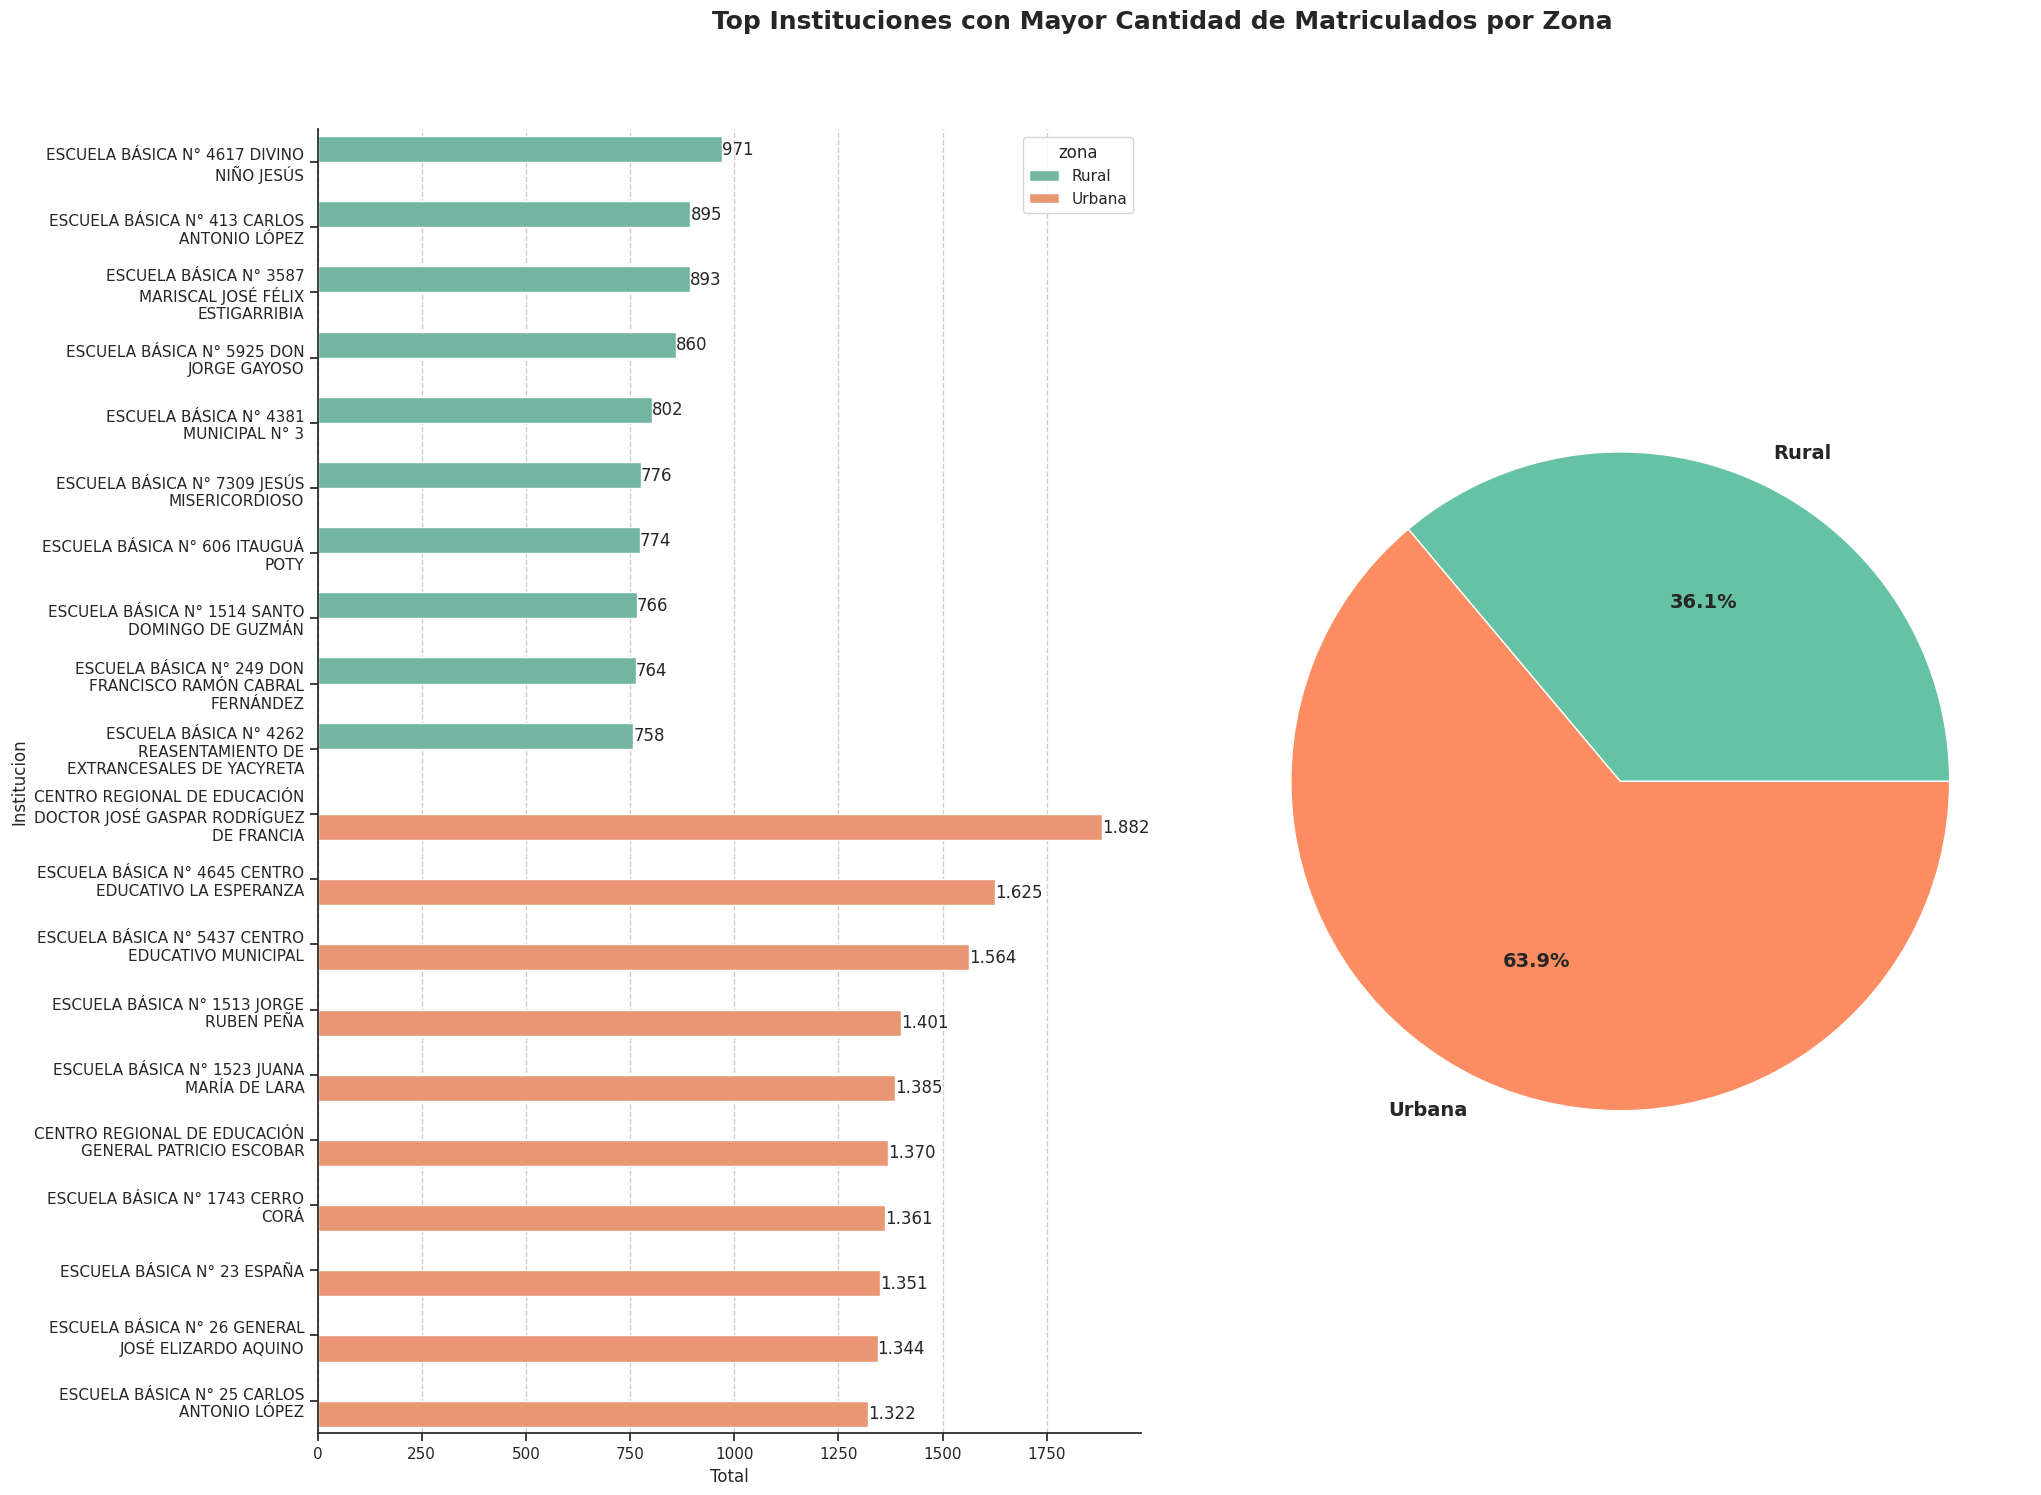

In [458]:
#Copiamos los datos en una variable
df_datos = df

#Removemos el indice 'departamento' para posteriormente establecer 'zona' e 'institucion' como nuevos indices
df_datos = df_datos.reset_index()
df_datos = df_datos.set_index(['zona','institucion'])

#Agrupamos los datos y ordenamos el 'total_matriculados' de mayor a menor
df_top_zona_institucion = df_datos.groupby(level=0, group_keys=False).apply(lambda x: x.sort_values('total_matriculados', ascending=False))

#Agrupamos nuevamento para obtener el top 10 instituciones de cada departamento
df_top_zona_institucion = df_top_zona_institucion.groupby(level=0).head(10)[['departamento', 'distrito', 'total_matriculados']]

#Exportamos a csv
df_top_zona_institucion.to_csv('data/resumen_top_zona_institucion_total.csv', encoding = 'utf-8-sig')


#Quitamos los indices
df_top_zona_institucion = df_top_zona_institucion.reset_index()

# Establecemos la sesión como no-interactiva.
plt.close('all')
plt.ioff()


# Creamos 2 subgraficos
fig, axes = plt.subplots(1, 2, figsize=(18,15))

# Configuraciones de espaciados y ajustes visuales de los graficos
fig.tight_layout()
fig.subplots_adjust(top=0.9)


# Definimos el titulo general del los graficos
plt.suptitle('Top Instituciones con Mayor Cantidad de Matriculados por Zona', fontsize = 18, fontweight='bold', verticalalignment='top')

# Definimos la paleta de colores para ambos subgraficos
paleta_colores = sns.color_palette("Set2")



# Diagramamos el gráfico de barras el primer subgrafico
sns.barplot(data=df_top_zona_institucion, y='institucion', x='total_matriculados', hue='zona', palette=paleta_colores, ax=axes[0])


# Cambios visuales del primer subgrafico
axes[0].set(ylabel = 'Institucion', xlabel = 'Total')
axes[0].bar_label(axes[0].containers[0], fontsize = 12, labels = [f'{x:,.0f}'.replace(',', '.') for x in axes[0].containers[0].datavalues])
axes[0].bar_label(axes[0].containers[1], fontsize = 12, labels = [f'{x:,.0f}'.replace(',', '.') for x in axes[0].containers[1].datavalues])
axes[0].yaxis.grid(False)
axes[0].xaxis.grid(True)
# Reorganiza los labels del eje y, debido a que poseen una longitud alta
axes[0].set_yticklabels(textwrap.fill(x.get_text(), 30) for x in axes[0].get_yticklabels())



## Segundo subgrafico
# Agrupamos los datos por zona
datos_instituciones_zonas = df_top_zona_institucion.groupby(['zona'], as_index=False).agg({'total_matriculados':'sum'})

# Creamos un grafico de torta como segundo subgrafico
grafico_torta = datos_instituciones_zonas.plot(kind='pie', ax=axes[1], autopct = '%0.1f%%',
                                                y = 'total_matriculados', labels = datos_instituciones_zonas['zona'], 
                                                legend = False, colors = paleta_colores, textprops={'fontsize': 14, 'weight':'bold'})

# Configuracion visual del segundo subgrafico
grafico_torta.axes.get_yaxis().set_visible(False)

# Mostramos el gráfico.
plt.show()



<h5>MACHINE LEARNING</h6>

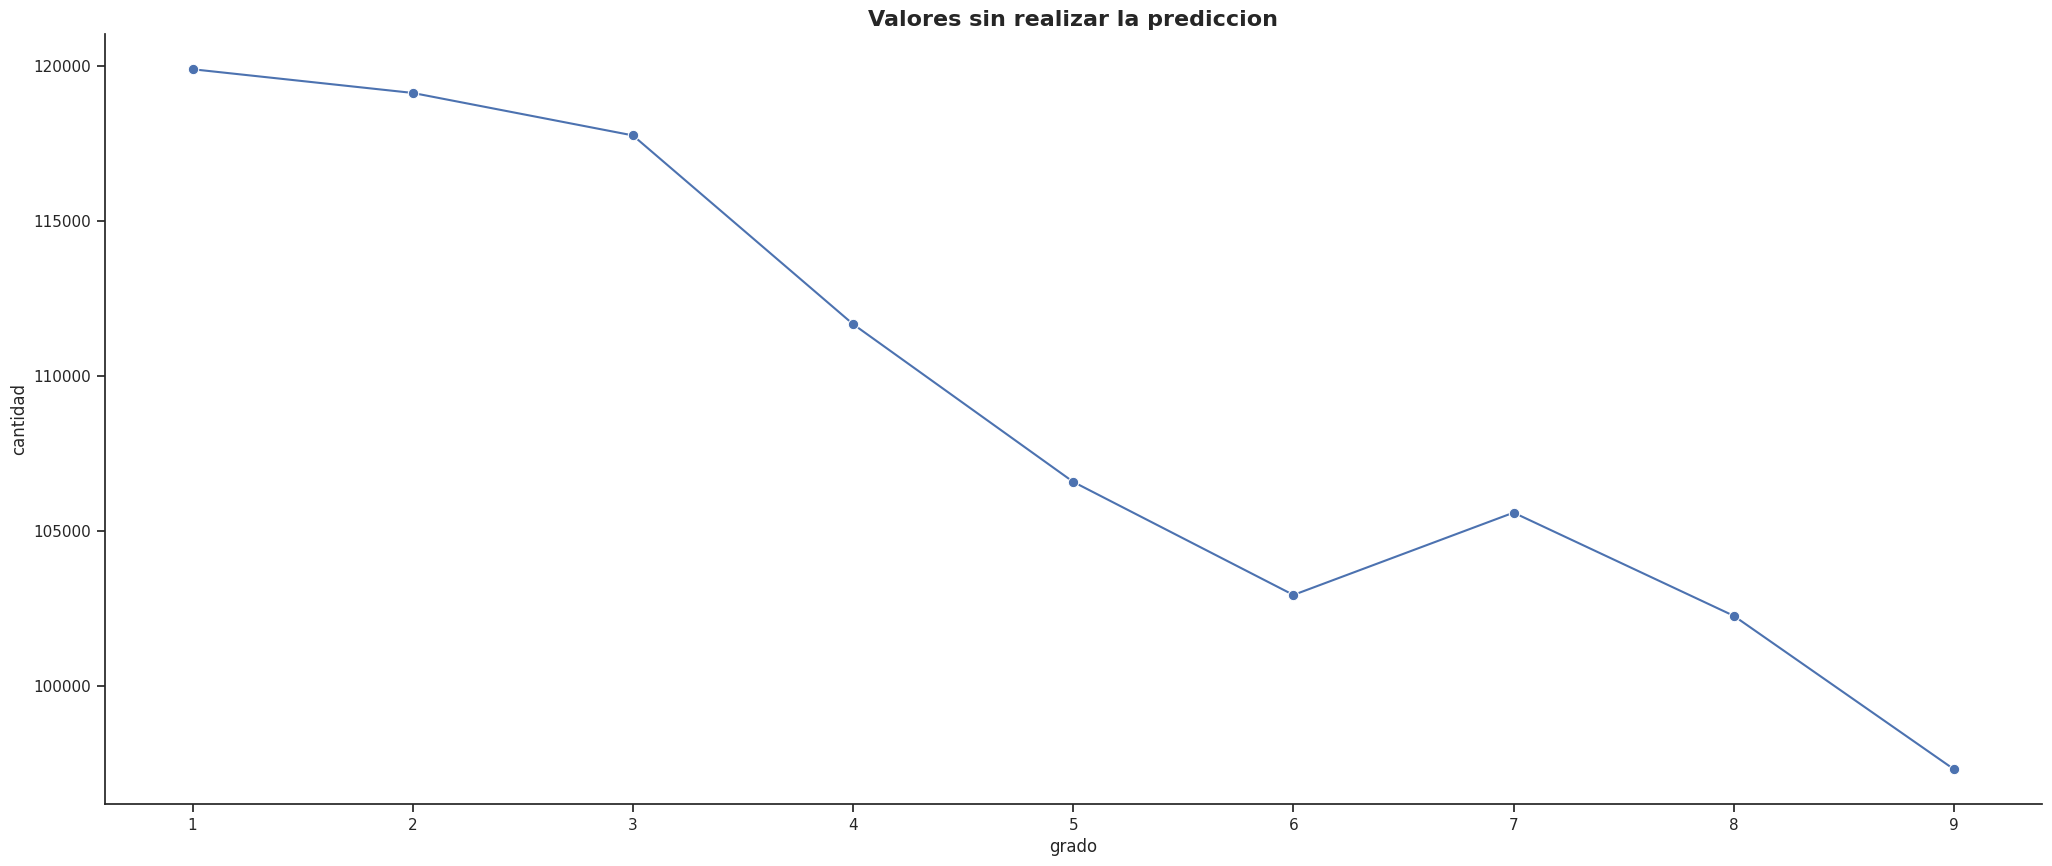

In [459]:
#Modelo elegido: Regresion Lineal
#Hipotesis: a menor grado, mayor cantidad de inscriptos

from sklearn.linear_model import LinearRegression
from sklearn import metrics

#Obtenemos los datos para utilizar en el modelo
df_totales_grado = df_totales_grado.rename(columns={'tipo':'grado'})
df_totales_grado['grado'] = df_totales_grado['grado'].str[0]
x = df_totales_grado[['grado']]
y = df_totales_grado['cantidad']


ax1 = sns.lineplot(x='grado', y='cantidad', data=df_totales_grado, marker='.', markersize=15)
ax1.set_title('Valores sin realizar la prediccion', fontdict= { 'fontsize': 16, 'fontweight':'bold'})
plt.show()


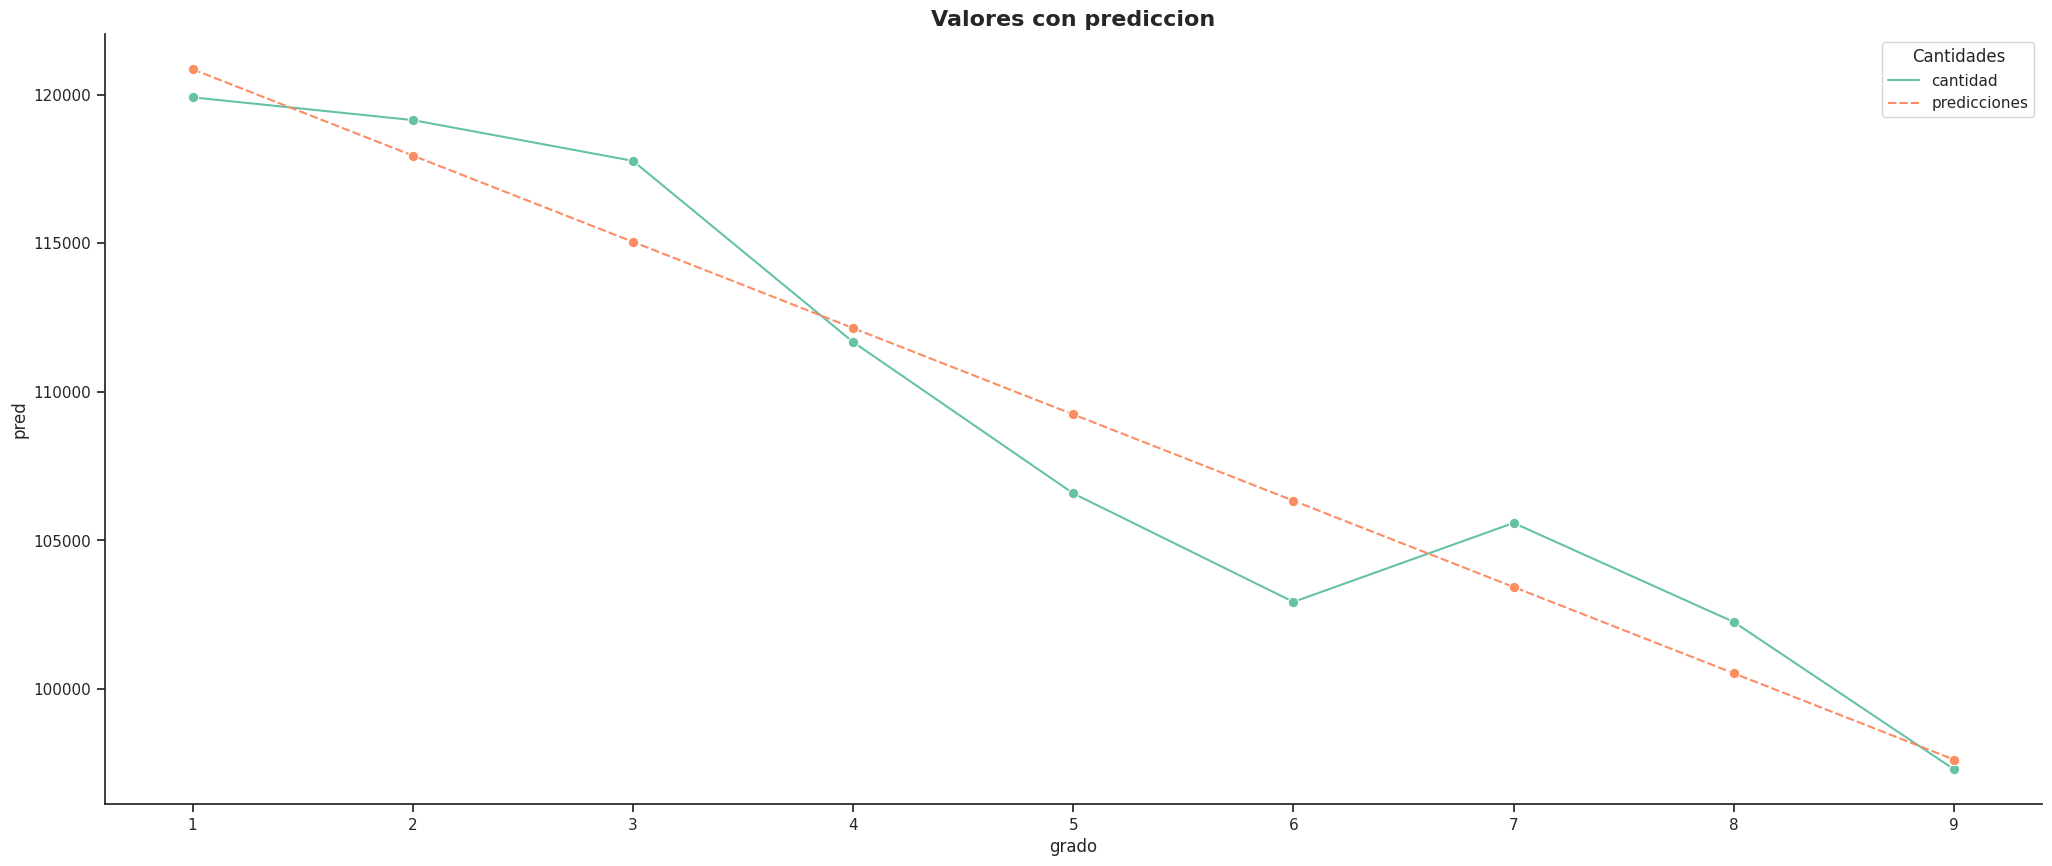

In [460]:
#Instanciamos el modelo
model = LinearRegression()
model.fit(X=x, y=y)

#realizamos las predicciones
df_totales_grado['predicciones'] = model.predict(X=x)


ax2 = sns.lineplot(data=df_totales_grado.melt(id_vars='grado', value_name='pred', var_name='Cantidades'),
                                    x='grado', y='pred', hue='Cantidades', style='Cantidades', palette='Set2', marker='.', markersize=15)

ax2.set_title('Valores con prediccion', fontdict= { 'fontsize': 16, 'fontweight':'bold'})


plt.show()

In [461]:
print(f'La puntacion del modelo es: {model.score(X=x, y=y):2.2%}')

media = metrics.mean_absolute_percentage_error(df_totales_grado['cantidad'], df_totales_grado['predicciones'])
print(f'La puntacion del modelo utilizando la metrica "promedio de error absoluto": {media:.2}%')



La puntacion del modelo es: 93.29%
La puntacion del modelo utilizando la metrica "promedio de error absoluto": 0.016%
